In [1]:
import numpy as np, healpy as hp, curvedsky as cs, cmb, tools_multitracer as mass, basic, cosmology, tqdm, local, plottools as pl
from scipy.integrate import quad
from matplotlib.pyplot import *
from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [2]:
zmin, zmax = 1e-3, 50.
zn = 3000
H0, Om, Ov, w0, wa = 70., .3, .7, -1., 0.

In [3]:
cps = {'H0':H0,'Om':Om,'Ov':Ov,'w0':w0,'wa':wa}
zi  = np.linspace(zmin,zmax,zn)
dz  = zi[1]-zi[0]
Hzi = basic.cosmofuncs.hubble(zi,divc=True,**cps)
rzi = basic.cosmofuncs.dist_comoving(zi,**cps)
rzs = basic.cosmofuncs.dist_comoving([1100.],**cps)[0]
Dzi = basic.cosmofuncs.growth_factor(zi,normed=True,**cps)

### Setup survey parameters

In [4]:
# CIB
nu = 535.

In [5]:
# galaxy survey parameters
g_survey = ['euclid','lsst']
zbn   = {'euclid':3,'lsst':3}
z0    = {'euclid':.9/np.sqrt(2.),'lsst':.3}
nz_b  = {'euclid':1.5,'lsst':1.}
sigma = {'euclid':.05,'lsst':.05}

In [6]:
zbin, dndzi, pz = {}, {}, {}
for survey in g_survey:
    zbin[survey]  = basic.galaxy.zbin(zbn[survey],2.,nz_b[survey],z0=z0[survey])
    dndzi[survey] = basic.galaxy.dndz_sf(zi,2.,nz_b[survey],z0=z0[survey])
    pz[survey]    = {zid: basic.galaxy.photoz_error(zi,[zbin[survey][zid],zbin[survey][zid+1]],sigma=sigma[survey],zbias=0.) for zid in range(zbn[survey])}

### Compute weight

In [7]:
w = {}
tracers = ['k','I']
for survey in g_survey:
    for zid in range(zbn[survey]):
        tracers += [survey[0]+str(zid)]
        w[survey[0]+str(zid)] = dndzi[survey]*pz[survey][zid]
print(tracers)

['k', 'I', 'e0', 'e1', 'e2', 'l0', 'l1', 'l2']


In [8]:
w['I'] = cosmology.window_cib(rzi,zi,nu)/Hzi/2.7255e6

0.01578809101673722


In [9]:
w['k'] = cosmology.window_kap(rzi,zi,rzs,Om,H0/3e5)/Hzi

### Compute Cl

In [10]:
lmin, lmax = 5, 2048
ln = 200
l  = np.linspace(lmin,lmax,ln)
ll = np.linspace(lmin,lmax,lmax-lmin+1)

In [11]:
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

pars = camb.CAMBparams()
pars.set_cosmology(H0=cps['H0'], ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both
#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
s = 0.
pars.SourceWindows = [
    SplinedSourceWindow(z=zi, W = w['I'], dlog10Ndm=s, bias=np.sum(w['I']*dz)), 
    SplinedSourceWindow(z=zi, W = w['e0'], dlog10Ndm=s, bias=np.sum(w['e0']*dz), bias_z=np.sqrt(1.+zi)), 
    SplinedSourceWindow(z=zi, W = w['e1'], dlog10Ndm=s, bias=np.sum(w['e1']*dz), bias_z=np.sqrt(1.+zi)),
    SplinedSourceWindow(z=zi, W = w['e2'], dlog10Ndm=s, bias=np.sum(w['e2']*dz), bias_z=np.sqrt(1.+zi)), 
    SplinedSourceWindow(z=zi, W = w['l0'], dlog10Ndm=s, bias=np.sum(w['l0']*dz), bias_z=np.sqrt(1.+zi)),
    SplinedSourceWindow(z=zi, W = w['l1'], dlog10Ndm=s, bias=np.sum(w['l1']*dz), bias_z=np.sqrt(1.+zi)), 
    SplinedSourceWindow(z=zi, W = w['l2'], dlog10Ndm=s, bias=np.sum(w['l2']*dz), bias_z=np.sqrt(1.+zi))
]

In [12]:
# turning off GR corrections as they impact on large-scale (ell<20) for galaxy and should not present in CIB
pars.SourceTerms.counts_redshift = False 
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False

In [13]:
results = camb.get_results(pars)
cls = results.get_source_cls_dict()

### Compute P(k)

In [14]:
# compute linear matter P(k)
k, pk0 = cosmology.camb_pk(H0=H0,Om=Om,z=[0.],kmax=100.,minkh=1e-5,maxkh=50,npoints=1000)
Pk = spline(k,pk0)

In [15]:
cl = {}
for I, m0 in enumerate(tracers):
    for J, m1 in enumerate(tracers):
        if J<I: continue
        cl[m0+m1] = np.zeros(lmax-lmin+1)
        cli = np.zeros(ln)
        for i, L in tqdm.tqdm(enumerate(l),desc=m0+m1):
            integ  = (dz/Hzi) * (Hzi/rzi)**2 * w[m0] * w[m1] * Dzi**2*Pk(L/rzi)  
            cli[i] = np.sum(integ[:-1])
        cl[m0+m1] = spline(l,cli)(ll)

kk: 200it [00:00, 3640.15it/s]
kI: 200it [00:00, 3519.88it/s]
ke0: 200it [00:00, 3525.45it/s]
ke1: 200it [00:00, 3763.26it/s]
ke2: 200it [00:00, 3887.63it/s]
kl0: 200it [00:00, 3133.13it/s]
kl1: 200it [00:00, 3212.78it/s]
kl2: 200it [00:00, 3541.81it/s]
II: 200it [00:00, 3797.73it/s]
Ie0: 200it [00:00, 3754.05it/s]
Ie1: 200it [00:00, 3627.46it/s]
Ie2: 200it [00:00, 3955.25it/s]
Il0: 200it [00:00, 3035.50it/s]
Il1: 200it [00:00, 3069.02it/s]
Il2: 200it [00:00, 3391.63it/s]
e0e0: 200it [00:00, 2658.76it/s]
e0e1: 200it [00:00, 3809.87it/s]
e0e2: 200it [00:00, 3902.64it/s]
e0l0: 200it [00:00, 3643.32it/s]
e0l1: 200it [00:00, 3721.08it/s]
e0l2: 200it [00:00, 3864.36it/s]
e1e1: 200it [00:00, 3883.04it/s]
e1e2: 200it [00:00, 3626.44it/s]
e1l0: 200it [00:00, 3774.95it/s]
e1l1: 200it [00:00, 3704.64it/s]
e1l2: 200it [00:00, 3700.23it/s]
e2e2: 200it [00:00, 3892.30it/s]
e2l0: 200it [00:00, 3784.70it/s]
e2l1: 200it [00:00, 3806.45it/s]
e2l2: 200it [00:00, 3715.39it/s]
l0l0: 200it [00:00, 3660.19i

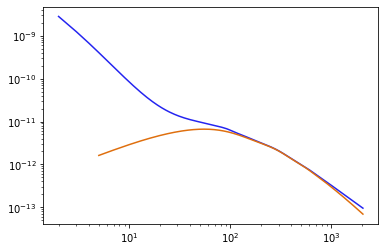

In [16]:
ls =  np.arange(2, lmax+1)
loglog(ls,cls["W1xW1"][2:lmax+1]*2*np.pi/ls/(ls+1))
plot(ll,cl['II'])

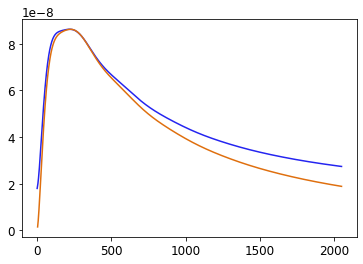

In [27]:
plot(ls,ls*cls["PxW1"][2:lmax+1]*(2*np.pi)/2/ls)
plot(ll,ll*cl['kI'])

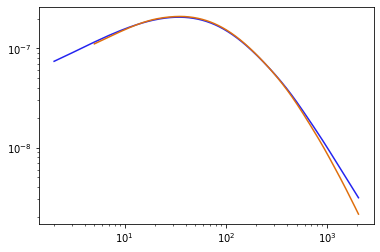

In [18]:
loglog(ls,cls["PxP"][2:lmax+1]*(2*np.pi)/4)
plot(ll,cl['kk'])

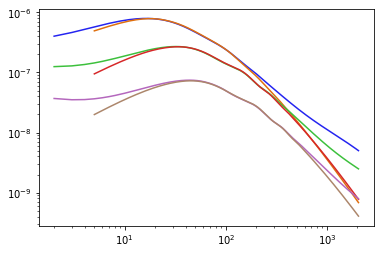

In [19]:
loglog(ls,cls["W2xW2"][2:lmax+1]*2*np.pi/ls/(ls+1))
plot(ll,cl['e0e0'])
loglog(ls,cls["W3xW3"][2:lmax+1]*2*np.pi/ls/(ls+1))
plot(ll,cl['e1e1'])
loglog(ls,cls["W4xW4"][2:lmax+1]*2*np.pi/ls/(ls+1))
plot(ll,cl['e2e2'])

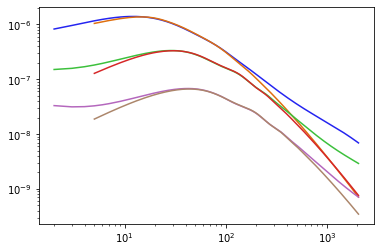

In [20]:
loglog(ls,cls["W5xW5"][2:lmax+1]*2*np.pi/ls/(ls+1))
plot(ll,cl['l0l0'])
loglog(ls,cls["W6xW6"][2:lmax+1]*2*np.pi/ls/(ls+1))
plot(ll,cl['l1l1'])
loglog(ls,cls["W7xW7"][2:lmax+1]*2*np.pi/ls/(ls+1))
plot(ll,cl['l2l2'])

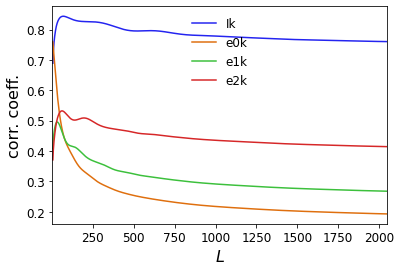

In [21]:
pl.plot_1dstyle(xmin=1,xmax=lmax,ylab='corr. coeff.')
plot(ll,cl['kI']/np.sqrt(cl['II']*cl['kk']),label='Ik')
for g in tracers:
    if 'e' in g:
        plot(ll,cl['k'+g]/np.sqrt(cl[g+g]*cl['kk']),label=g+'k')
legend()

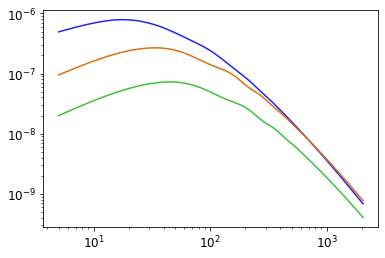

In [22]:
for g in tracers:
    if 'e' in g:
        loglog(ll,cl[g+g])

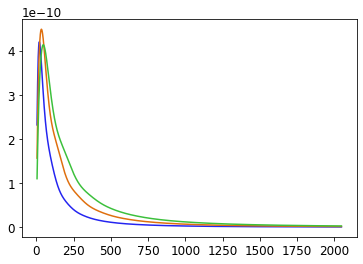

In [23]:
plot(ll,cl['Ie0'])
plot(ll,cl['Ie1'])
plot(ll,cl['Ie2'])

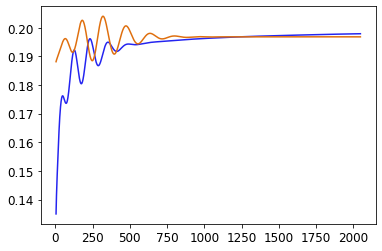

In [24]:
plot(ll,cl['e0e1']/np.sqrt(cl['e0e0']*cl['e1e1']))
plot(ll,cl['e1e2']/np.sqrt(cl['e1e1']*cl['e2e2']))